# 제 1차 해커톤 : 캐글 축제
- 캐글 대회 : [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview) 
- 데이터
    - 러시아 소프트웨어 회사의 판매실적 데이터
    - 다음 달의 판매량을 예측하는 문제
    - 평가 지표 : root mean sqaure error(rmse)
- 데이터 구성
    - sales_train.csv : 'date', 'date_block_num', 'shop_id', 'item_id', 'item_price','item_cnt_day'
        - 학습할 데이터, 2013년 1월부터 2015년 10월까지의 데이터가 있음(예측할 달은 2015년 11월 판매량)
    - test.csv : 'ID', 'shop_id', 'item_id'
        - test를 위한 파일
    - sample_submission.csv : 'ID', 'item_cnt_month'
        - 제출 파일 -> 월별 판매량 컬럼을 train 데이터에 생성해야한다는 것을 알 수 있음 
    - items.csv : 'item_name', 'item_id', 'item_category_id'
        - item 이름, 카테고리 아이디
    - item_categories.csv : 'item_category_name', 'item_category_id'
        - item 카테고리 이름
    - shops.csv : 'shop_name', 'shop_id'
        - shop 이름 
        
## 00. 해커톤 진행 과정 요약 
- 문제 정의 : **시계열 데이터**, **회귀 예측**로 해당 캐글 대회의 문제를 정의했습니다.
- 모델 선택 : 시계열 회귀 예측을 할 때 많이 사용되는 교차검증(Cross Validation)을 사용하고, 캐글에서 많이 사용되는 XGboost를 사용하기로 계획했습니다.   
- 데이터 분석 : 이상치, 중복 데이터에 대한 처리, 각 변수간의 상관관계, 데이터의 trend를 검증해 데이터를 분석하고자 했습니다. 
- 피쳐 생성 : 
    - 1년 전, 2년전 11월(예측하고자 하는 달)의 판매량
    - 러시아의 기후를 고려해 비슷한 날씨인 9-10월의 판매량
- 참고 :  
    **_캐글 대회와 데이터 처리에 대해 미숙한 점을 고려해, 기존에 공개되어 있는 [노트북](https://www.kaggle.com/plasticgrammer/future-sales-prediction-playground/notebook)을 참고해 데이터 처리 방법과 코드를 익히고자하였습니다.    
    저희 조는 해당 노트북을 베이스 라인으로, 데이터 분석, 모델과 하이퍼 파라미터를 조절하며 문제를 해결하였습니다._**   
    
### 1) 데이터 불러오기
- 각 데이터를 불러오고, 확인합니다. 

### 2) 데이터 분포 확인 및 이상치 처리
- 이상치를 없애는 방법으로 처리
- Statsmodel라이브러리를 이용해, 계절적 성분의 주기 확인 

### 3) 데이터 전처리(새로운 피쳐 생성) 및 데이터 분석
- test 파일에 있는 항목으로 train 데이터셋을 구성
- 중복 데이터 삭제 
- 피쳐를 만든 후에, 해당 데이터셋에 merge, aggregation하는 방식으로 최종 데이터셋을 구성
- 각 변수의 상관관계를 groupby를 이용해 추세 확인 
    - shop, item 각 항목과 판매량의 상관관계 확인 
- shop.csv, item.csv, item_categories.csv를 이용해 새로운 피쳐를 생성 
- 각 데이터의 평균값, 중앙값, 표준편차를 계산해 피쳐로 생성
- 이동평균, 주문량, 할인율, 이전 판매량(시차 적용)에 대한 피쳐 생성

### 4) 학습 및 평가
- 학습 전 메모리를 정리하고 생성한 피쳐 매트릭스를 통합
- group kfold, xgboost모델을 사용해 학습
        
## 01. 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, metrics

import os
from os.path import join

sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
# project 를 돌리는 환경 경로 설정
data_dir = os.getenv('HOME')+'/Projects/kaggle_hackathon/'

# csv 파일 경로 설정
train_data_path = join(data_dir, 'sales_train.csv')
sub_data_path = join(data_dir, 'sample_submission.csv')
test_data_path = join(data_dir, 'test.csv')
shops_data_path = join(data_dir, 'shops.csv')
items_data_path = join(data_dir, 'items.csv')
items_cat_path = join(data_dir, 'item_categories.csv')

print(train_data_path)
print(sub_data_path)
print(test_data_path)
print(shops_data_path)
print(items_data_path)
print(items_cat_path)

/home/aiffel-dj26/Projects/kaggle_hackathon/sales_train.csv
/home/aiffel-dj26/Projects/kaggle_hackathon/sample_submission.csv
/home/aiffel-dj26/Projects/kaggle_hackathon/test.csv
/home/aiffel-dj26/Projects/kaggle_hackathon/shops.csv
/home/aiffel-dj26/Projects/kaggle_hackathon/items.csv
/home/aiffel-dj26/Projects/kaggle_hackathon/item_categories.csv


In [3]:
# 일자 포맷 parser 설정
parser = lambda date: pd.to_datetime(date, format='%d.%m.%Y')

# 일자 포맷 설정
train = pd.read_csv(train_data_path, parse_dates=['date'], date_parser=parser)
sub = pd.read_csv(sub_data_path)
test = pd.read_csv(test_data_path)

shops = pd.read_csv(shops_data_path)
items = pd.read_csv(items_data_path)
item_cats = pd.read_csv(items_cat_path)

print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(sub.shape))
print('test data dim : {}'.format(test.shape))

print('shops data dim : {}'.format(shops.shape))
print('items data dim : {}'.format(items.shape))
print('item_cats data dim : {}'.format(item_cats.shape))

train data dim : (2935849, 6)
sub data dim : (214200, 2)
test data dim : (214200, 3)
shops data dim : (60, 2)
items data dim : (22170, 3)
item_cats data dim : (84, 2)


In [4]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.000,1.000
1,2013-01-03,0,25,2552,899.000,1.000
2,2013-01-05,0,25,2552,899.000,-1.000
3,2013-01-06,0,25,2554,"1,709.050",1.000
4,2013-01-15,0,25,2555,"1,099.000",1.000


## 02. 데이터 분포 확인 (이상치 검출)

<AxesSubplot:xlabel='item_price'>

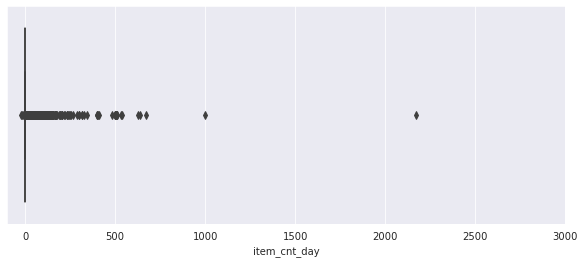

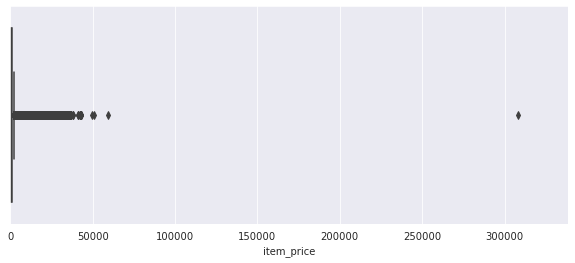

In [5]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

### 이상치를 잘라 줍니다. 
- item_cnt_day 1000이하
- item_price 10000이하

In [6]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1000]

### 0~33 월까지 있는지 확인합니다.

In [7]:
print(train['date_block_num'].max())

33


In [8]:
print(train['item_cnt_day'].describe())

count   2,935,846.000
mean            1.242
std             2.218
min           -22.000
25%             1.000
50%             1.000
75%             1.000
max           669.000
Name: item_cnt_day, dtype: float64


In [9]:
train['item_cnt_day'].nlargest(25).values

array([669., 637., 624., 539., 533., 512., 508., 504., 502., 501., 500.,
       500., 480., 412., 405., 401., 401., 343., 325., 313., 313., 300.,
       299., 288., 264.])

## 일별 판매량 추이

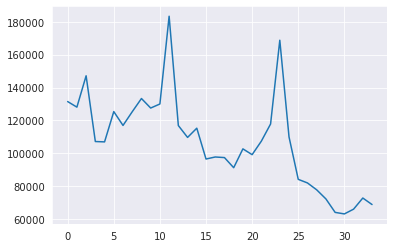

In [10]:
sales_by_day = train.groupby('date_block_num')['item_cnt_day'].sum().tolist()
plt.plot(sales_by_day)

### Seasonality 분석 

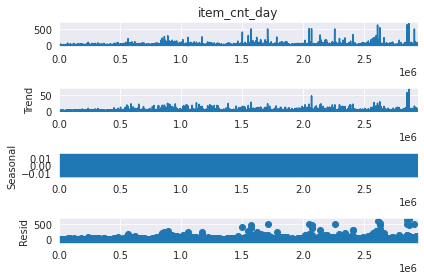

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train['item_cnt_day'], model='additive', two_sided=True, 
                            period=34, extrapolate_trend='freq') 
result.plot()
plt.show()

## 03. 데이터 전처리
### 정확도를 위해 test에 있는 item_id만 남깁니다.
- train, test에 중복되는 컬럼 : item_id
- 보다 정확하게 예측하기 위해서 test에 있는 item_id로만 학습

In [12]:
# train 과 test 의 상품 수 차이를 구하기 위해서, unique 를 사용하여 확인한다. 총 363개의 item 의 차이가 있다.
test_only = set(test['item_id'].unique()) - set(train['item_id'].unique())
print('test only items:', len(test_only))

test only items: 363


###  subset컬럼에서 중복되는 데이터 삭제

In [13]:
# 동일한 날짜, 동일한 월수, 상점 id, 상품 id, 판매량의 중복된 정보를 drop 해준다.
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=subset).value_counts())
train.drop_duplicates(subset=subset, inplace=True)

False    2935822
True          24
dtype: int64


In [14]:
# test 셋의 상점, 상품 id 로만 train 을 시킬 예정이기 때문에, unique 를 사용하여 구별해준다.
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()

# train 셋의 상점, 상품 중 test 셋에 존재하는 정보만 재구성한다.
train = train[train.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]

print('train:', train.shape)

train: (1224427, 6)


### 베이스가 될 데이터셋을 만들어줍니다.

In [15]:
from itertools import product          # 조합을 위한 모듈

# create all combinations
# 1)월 순차 * test 셋의 shop id product 연산으로 이루어진 dataframe 생성
block_shop_combi = pd.DataFrame(list(product(np.arange(34), test_shops)), columns=['date_block_num','shop_id'])
# 2)items * shops product 연산으로 이루어진 dataframe 생성
shop_item_combi = pd.DataFrame(list(product(test_shops, test_items)), columns=['shop_id','item_id'])
# 1)를 2) 안에 merge 해준다. shop_id 안에 items 를 넣어준다.
all_combi = pd.merge(block_shop_combi, shop_item_combi, on=['shop_id'], how='inner')

# 월별 판매량 계산을 위해 date_blaco_num을 기준으로 groupby, train_grp생성 
# 위의 all-combi 를 train 에 merge 해준다
train_base = pd.merge(all_combi, train, on=['date_block_num','shop_id','item_id'], how='left')
# item count day 중 빈 값은 0 으로 채운다
train_base['item_cnt_day'].fillna(0, inplace=True)
# train_base 에서 group으로 묶어 train_grp 을 만들어준다
train_grp = train_base.groupby(['date_block_num','shop_id','item_id'])

In [16]:
train_base.head()

,date_block_num,shop_id,item_id,date,item_price,item_cnt_day
0,0,5,5037,NaT,NaN,0.000
1,0,5,5320,NaT,NaN,0.000
2,0,5,5233,NaT,NaN,0.000
3,0,5,5232,NaT,NaN,0.000
4,0,5,5268,NaT,NaN,0.000


In [17]:
# train_base 찍어보면 원하는대로 나온다
train_base.shape

(7907069, 6)

## 03-2. 피쳐 생성
### 예측을 위한 월별 판매량 컬럼 생성

In [18]:
# summary count by month
# train_grp 에서 일별 판매량을 누적/카운트 하여 train_monthly 를 만들어준다
train_monthly = pd.DataFrame(train_grp.agg({'item_cnt_day':['sum','count']})).reset_index()
# train_monthly 에 column 을 이름 짓기
train_monthly.columns = ['date_block_num','shop_id','item_id','item_cnt','item_order']
print(train_monthly[['item_cnt','item_order']].describe())

# trim count
# 일일 판매량을 0-20 값으로 clip 시킴
train_monthly['item_cnt'].clip(0, 20, inplace=True)

train_monthly.head()

           item_cnt    item_order
count 7,282,800.000 7,282,800.000
mean          0.222         1.086
std           3.197         0.725
min          -4.000         1.000
25%           0.000         1.000
50%           0.000         1.000
75%           0.000         1.000
max       1,305.000        31.000


,date_block_num,shop_id,item_id,item_cnt,item_order
0,0,2,30,0.000,1
1,0,2,31,0.000,1
2,0,2,32,0.000,1
3,0,2,33,1.000,1
4,0,2,38,0.000,1


### 월별 판매량 추이

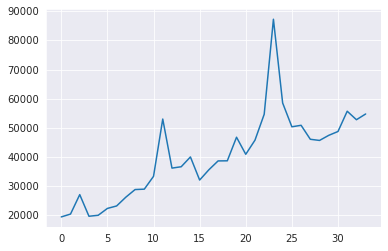

In [19]:
sales_by_month = train_monthly.groupby('date_block_num')['item_cnt'].sum().tolist()
plt.plot(sales_by_month)

### item별 월별 판매량

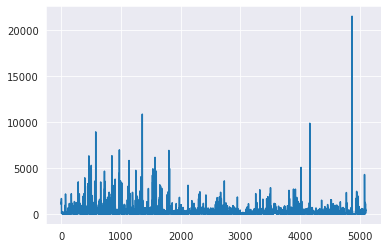

In [20]:
sales_by_item = train_monthly.groupby('item_id')['item_cnt'].sum().tolist()
plt.plot(sales_by_item)

### shop별 월별 판매량

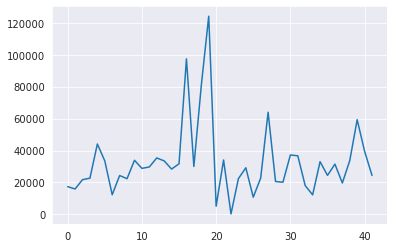

In [21]:
sales_by_shop = train_monthly.groupby('shop_id')['item_cnt'].sum().tolist()
plt.plot(sales_by_shop)

### item, item category 전처리

In [22]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [23]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


**item 카테고리 중 첫번째 글자(띄어쓰기 기준)만 카테고리 이름으로 사용한다.**
- 뽑아낸 첫번째 글자를 숫자로 변환한다.(pd.Categorical)
- 변환한 숫자를 아이템 그룹 넘버로 사용한다.

In [24]:
# 상품명 중 상품 카테고리(띄어쓰기 앞부분)을 넣어준다.
item_grp = item_cats['item_category_name'].apply(lambda x: str(x).split(' ')[0])
# 카테고리를 index 화 시켜준다.
item_cats['item_group'] = pd.Categorical(item_grp).codes
# 카테고리 index, 카테고리를 items 에 merge 해준다.
items = pd.merge(items, item_cats.loc[:,['item_category_id','item_group']], on=['item_category_id'], how='left')
# head 찍어보기
items.head()

,item_name,item_id,item_category_id,item_group
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,7
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,11
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,7
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,7
4,***КОРОБКА (СТЕКЛО) D,4,40,7


### shop 이름에 대해서도 아이템 카테고리와 똑같이 전처리한다. 
**첫번째 글자가 해당 도시이름이기 때문에 city 컬럼으로 만들어준다.**

In [25]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [26]:
# 상점 이름에서 ! 를 삭제, 띄어쓰기로 분리하여 0번째 정보가 도시 정보
city = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
# 상점명에서 도시명을 추출하여 index화 시켜준다.
shops['city'] = pd.Categorical(city).codes
# head 찍어보기
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,29
1,"!Якутск ТЦ ""Центральный"" фран",1,29
2,"Адыгея ТЦ ""Мега""",2,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1
4,"Волжский ТЦ ""Волга Молл""",4,2


**shop, item을 기준으로 분류해, 판매량과 주문량에 대한 평균, 중앙값, 표준편차값을 계산합니다.**

In [27]:
# 상점/상품으로 그룹화하여 통계 확인.
grp = train_monthly.groupby(['shop_id', 'item_id'])
# 판매량 특성은 평균, 중간값, 편차, / 판매건수 특성은 평균으로 설정한다.
train_shop = grp.agg({'item_cnt':['mean','median','std'],'item_order':'mean'}).reset_index()
# 샵별 정보 칼럼을 생성해준다.
train_shop.columns = ['shop_id','item_id','cnt_mean_shop','cnt_med_shop','cnt_std_shop','order_mean_shop']
print(train_shop[['cnt_mean_shop','cnt_med_shop','cnt_std_shop']].describe())
# head 찍어보기
train_shop.head()

       cnt_mean_shop  cnt_med_shop  cnt_std_shop
count    214,200.000   214,200.000   214,200.000
mean           0.188         0.054         0.381
std            0.608         0.509         0.773
min            0.000         0.000         0.000
25%            0.000         0.000         0.000
50%            0.029         0.000         0.171
75%            0.147         0.000         0.431
max           20.000        20.000        10.055


,shop_id,item_id,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop
0,2,30,0.118,0.000,0.327,1.000
1,2,31,0.235,0.000,0.741,1.088
2,2,32,0.324,0.000,0.638,1.088
3,2,33,0.324,0.000,0.535,1.029
4,2,38,0.000,0.000,0.000,1.000


**shop 카테고리에 대한 평균값을 계산합니다.**

In [28]:
# 상품 df 에 월간판매량을 추가한다.
train_cat_monthly = pd.merge(train_monthly, items, on=['item_id'], how='left')
# train cat monthly 에서 상점/상품 별로 통계를 낸다.
grp = train_cat_monthly.groupby(['shop_id', 'item_group'])
# 상품 판매량 평균을 넣는다
train_shop_cat = grp.agg({'item_cnt':['mean']}).reset_index()
# 칼럼 이름을 설정해준다.
train_shop_cat.columns = ['shop_id','item_group','cnt_mean_shop_cat']
print(train_shop_cat.loc[:,['cnt_mean_shop_cat']].describe())
# head 찍어보기
train_shop_cat.head()

       cnt_mean_shop_cat
count            546.000
mean               0.925
std                2.172
min                0.000
25%                0.029
50%                0.149
75%                0.467
max               13.382


,shop_id,item_group,cnt_mean_shop_cat
0,2,0,0.000
1,2,1,0.352
2,2,3,0.000
3,2,4,0.196
4,2,5,0.292


**1, 2, 12개월 전 판매량에 대한 피쳐 생성**

In [29]:
# 데이터셋을 복사후, 만들고자하는 컬럼을 미리 지정합니다.
train_prev = train_monthly.copy()  # train monthly 를 복사해서
train_prev['date_block_num'] = train_prev['date_block_num'] + 1  # trainprev 에 1씩 더해준다
train_prev.columns = ['date_block_num','shop_id','item_id','cnt_prev','order_prev'] # 칼럼명을 설정해준다.

# 이전 판매량 정보를 복사해서 머지한다.
for i in [2,12]:
    train_prev_n = train_monthly.copy()
    train_prev_n['date_block_num'] = train_prev_n['date_block_num'] + i
    train_prev_n.columns = ['date_block_num','shop_id','item_id','cnt_prev' + str(i),'order_prev' + str(i)]
    train_prev = pd.merge(train_prev, train_prev_n, on=['date_block_num','shop_id','item_id'], how='left')

train_prev.head()

,date_block_num,shop_id,item_id,cnt_prev,order_prev,cnt_prev2,order_prev2,cnt_prev12,order_prev12
0,1,2,30,0.000,1,NaN,NaN,NaN,NaN
1,1,2,31,0.000,1,NaN,NaN,NaN,NaN
2,1,2,32,0.000,1,NaN,NaN,NaN,NaN
3,1,2,33,1.000,1,NaN,NaN,NaN,NaN
4,1,2,38,0.000,1,NaN,NaN,NaN,NaN


In [30]:
# By month,shop,item_group At previous
grp = pd.merge(train_prev, items, on=['item_id'], how='left').groupby(['date_block_num','shop_id','item_group']) # group 하여 merge
train_cat_prev = grp['cnt_prev'].mean().reset_index() # 이전 판매량의 평균을 내서
train_cat_prev = train_cat_prev.rename(columns={'cnt_prev':'cnt_prev_cat'}) # 칼럼 명을 변경한다.

train_cat_prev.head() # head 출력

,date_block_num,shop_id,item_group,cnt_prev_cat
0,1,2,0,0.000
1,1,2,1,0.280
2,1,2,3,0.000
3,1,2,4,0.000
4,1,2,5,0.100


In [31]:
# pivot 시켜줌
train_piv = train_monthly.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values='item_cnt', aggfunc=np.sum, fill_value=0)
train_piv = train_piv.reset_index()  # index reset
train_piv.head()   # head 출력

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
4,2,38,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**이동평균에 대한 피쳐 생성**

In [32]:
# MACD At previous
col = np.arange(34)   # [0...33] column 숫자 세팅
pivT = train_piv[col].T   # train_piv 를 tranpose
ema_s = pivT.ewm(span=4).mean().T   # 4개월 지수이동평균 계산
ema_m = pivT.ewm(span=12).mean().T   # 12개월 지수이동평균 계산
ema_l = pivT.ewm(span=26).mean().T   # 26개월 지수이동평균 계산
macd = ema_s - ema_l   # 단기-장기 이동평균값 계산
sig = macd.ewm(span=9).mean()   # 9개월 이동평균값의 평균 계산

ema_list = []
for c in col:
    sub_ema = pd.concat([train_piv.loc[:,['shop_id','item_id']],
        # 칼럼명 변경
        pd.DataFrame(ema_s.loc[:,c]).rename(columns={c:'cnt_ema_s_prev'}),
        pd.DataFrame(ema_m.loc[:,c]).rename(columns={c:'cnt_ema_m_prev'}),
        pd.DataFrame(ema_l.loc[:,c]).rename(columns={c:'cnt_ema_l_prev'}),
        pd.DataFrame(macd.loc[:,c]).rename(columns={c:'cnt_macd_prev'}),
        pd.DataFrame(sig.loc[:,c]).rename(columns={c:'cnt_sig_prev'})], axis=1)
    sub_ema['date_block_num'] = c + 1
    ema_list.append(sub_ema)

# ema_list 를 concat 해준다
train_ema_prev = pd.concat(ema_list)
# head 찍어보기
train_ema_prev.head()

,shop_id,item_id,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,date_block_num
0,2,30,0.000,0.000,0.000,0.000,0.000,1
1,2,31,0.000,0.000,0.000,0.000,0.000,1
2,2,32,0.000,0.000,0.000,0.000,0.000,1
3,2,33,1.000,1.000,1.000,0.000,0.000,1
4,2,38,0.000,0.000,0.000,0.000,0.000,1


In [33]:
# Price mean by month,shop,item
train_price = train_grp['item_price'].mean().reset_index()
# null 아닌 값 만 담기
price = train_price[~train_price['item_price'].isnull()]
# price head 찍어보기
price.head()

,date_block_num,shop_id,item_id,item_price
3,0,2,33,499.000
71,0,2,482,"3,300.000"
73,0,2,491,600.000
143,0,2,839,"3,300.000"
175,0,2,1007,449.000


In [34]:
# last price by shop,item
# 가장 최근 가격정보를 설정
last_price = price.drop_duplicates(subset=['shop_id', 'item_id'], keep='last').drop(['date_block_num'], axis=1)

In [35]:
# null price by shop,item
# 상품 정보 중복값을 제외하고 모아서
uitem = price['item_id'].unique()
# 상품 가격정보 set 을 생성, id col drop
pred_price_set = test[~test['item_id'].isin(uitem)].drop('ID', axis=1)

print(pred_price_set.shape)   # unique 한 각격의 총 수를 확인 가능
# head 찍어보기
pred_price_set.head()

(16128, 2)


,shop_id,item_id
1,5,5320
4,5,5268
45,5,5826
64,5,3538
65,5,3571


In [36]:
# 가격 추정치 셋이 존재하면,
if len(pred_price_set) > 0:
    train_price_set = pd.merge(price, items, on=['item_id'], how='inner') # train 셋 안에 item id 안에 merge
    pred_price_set = pd.merge(pred_price_set, items, on=['item_id'], how='inner').drop(['item_name'], axis=1) # test 셋item id 안에 merge
    reg = ensemble.ExtraTreesRegressor(n_estimators=25, n_jobs=-1, max_depth=15, random_state=42) # 앙상블 회귀 모델 설정
    reg.fit(train_price_set[pred_price_set.columns], train_price_set['item_price']) # 학습
    pred_price_set['item_price'] = reg.predict(pred_price_set) # 가격 정보 예상 값

test_price = pd.concat([last_price, pred_price_set], join='inner') # 가격 정보 예상 값 넣기
# head 찍어보기
test_price.head()

,shop_id,item_id,item_price
209,2,1204,299.000
211,2,1224,399.000
219,2,1247,299.000
826,2,3656,299.000
1064,2,4531,279.000


In [37]:
# 해당 상품의 역대 최대 가격(정가)를 설정하는 절차
price_max = price.groupby(['item_id']).max()['item_price'].reset_index() # 칼럼 reset index
price_max.rename(columns={'item_price':'item_max_price'}, inplace=True) # 칼럼 명 변경
price_max.head() # head 찍어보기

,item_id,item_max_price
0,30,399.000
1,31,699.000
2,32,349.000
3,33,499.000
4,38,"2,399.000"


In [38]:
# 정가대비 현재 판매가를 비교하여 할인율을 계산해주는 과정
train_price_a = pd.merge(price, price_max, on=['item_id'], how='left') # 정가 설정
train_price_a['discount_rate'] = 1 - (train_price_a['item_price'] / train_price_a['item_max_price']) # 할인율 계싼
train_price_a.drop('item_max_price', axis=1, inplace=True) # 정가 제거
train_price_a.head() # head 찍어보기

,date_block_num,shop_id,item_id,item_price,discount_rate
0,0,2,33,499.000,0.000
1,0,2,482,"3,300.000",0.000
2,0,2,491,600.000,0.000
3,0,2,839,"3,300.000",0.000
4,0,2,1007,449.000,0.626


In [39]:
# 정가 정보를 merge 해준다
test_price_a = pd.merge(test_price, price_max, on=['item_id'], how='left')
test_price_a.loc[test_price_a['item_max_price'].isnull(), 'item_max_price'] = test_price_a['item_price'] # 빈 element 를 채워준다
test_price_a['discount_rate'] = 1 - (test_price_a['item_price'] / test_price_a['item_max_price']) # 할인율을 계산해준다
test_price_a.drop('item_max_price', axis=1, inplace=True) # 정가정보를 삭제한다
test_price_a.head() # head 찍어보기

,shop_id,item_id,item_price,discount_rate
0,2,1204,299.000,0.000
1,2,1224,399.000,0.111
2,2,1247,299.000,0.000
3,2,3656,299.000,0.143
4,2,4531,279.000,0.067


메모리 최적화를 위한 함수

In [40]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

**전체 피쳐를 하나로 통합합니다.**

In [41]:
def mergeFeature(df): 
    df = pd.merge(df, items, on=['item_id'], how='left').drop('item_group', axis=1)
    df = pd.merge(df, item_cats, on=['item_category_id'], how='left')
    df = pd.merge(df, shops, on=['shop_id'], how='left')

    df = pd.merge(df, train_shop, on=['shop_id','item_id'], how='left')
    df = pd.merge(df, train_shop_cat, on=['shop_id','item_group'], how='left')
    df = pd.merge(df, train_prev, on=['date_block_num','shop_id','item_id'], how='left')
    df = pd.merge(df, train_cat_prev, on=['date_block_num','shop_id','item_group'], how='left')
    df = pd.merge(df, train_ema_prev, on=['date_block_num','shop_id','item_id'], how='left')

    df['month'] = df['date_block_num'] % 12
    days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
    df['days'] = df['month'].map(days).astype(np.int8)

    df.drop(['shop_id','shop_name','item_id','item_name','item_category_id','item_category_name','item_group'], axis=1, inplace=True)
    df.fillna(0.0, inplace=True)
    return reduce_mem_usage(df)

**12개월 전까지의 판매량을 피쳐로 생성했기때문에, 해당하는 시점의 데이터는 사용하지 않습니다.**

In [42]:
train_set = train_monthly[train_monthly['date_block_num'] >= 12]

train_set = pd.merge(train_set, train_price_a, on=['date_block_num','shop_id','item_id'], how='left')
train_set = mergeFeature(train_set)

train_set = train_set.join(pd.DataFrame(train_set.pop('item_order'))) # move to last column
X_train = train_set.drop(['item_cnt'], axis=1)

Y_train = train_set['item_cnt'].clip(0.,20.)
X_train.head()

Memory usage of dataframe is 871.85 MB --> 404.47 MB (Decreased by 53.6%)


,date_block_num,item_price,discount_rate,city,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop,cnt_mean_shop_cat,cnt_prev,...,order_prev12,cnt_prev_cat,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,month,days,item_order
0,12,0.000,0.000,0,0.118,0.000,0.327,1.000,0.039,0.000,...,1.000,0.040,0.023,0.105,0.139,-0.116,-0.116,0,31,1
1,12,0.000,0.000,0,0.235,0.000,0.741,1.088,0.039,0.000,...,1.000,0.040,0.020,0.220,0.355,-0.335,-0.238,0,31,1
2,12,119.000,0.659,0,0.324,0.000,0.638,1.088,0.039,0.000,...,1.000,0.040,0.000,0.000,0.000,0.000,-0.140,0,31,1
3,12,199.000,0.601,0,0.324,0.000,0.535,1.029,0.039,1.000,...,1.000,0.040,0.883,0.507,0.403,0.480,0.070,0,31,1
4,12,0.000,0.000,0,0.000,0.000,0.000,1.000,0.039,0.000,...,1.000,0.040,0.000,0.000,0.000,0.000,0.049,0,31,1


## 04. 테스트 데이터 정리
- 34번째 달을 예측하기 때문에 해당하는 date_block_num을 34로 생성
- 주문량 피쳐를 채워주고, train에 없는 ID컬럼은 삭제

In [43]:
test_set = test.copy()
test_set['date_block_num'] = 34

test_set = pd.merge(test_set, test_price_a, on=['shop_id','item_id'], how='left')
test_set = mergeFeature(test_set)

test_set['item_order'] = test_set['cnt_ema_s_prev'] #order_prev
test_set.loc[test_set['item_order'] == 0, 'item_order'] = 1

X_test = test_set.drop(['ID'], axis=1)
X_test.head()

assert(X_train.columns.isin(X_test.columns).all())

Memory usage of dataframe is 38.00 MB --> 18.18 MB (Decreased by 52.2%)


## 05. 학습
- lightgbm, xgboost를 사용해 학습
- group kfold를 이용해 교차 검증 
    - 'date_block_num'이 분리되지 않도록하기 위해 group을 사용

In [44]:
from sklearn import linear_model, preprocessing
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score


folds = GroupKFold(n_splits=6)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

In [45]:
for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train, X_train['date_block_num'])):
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train[val_]
    
    model = xgb.XGBRegressor(
    max_depth=7,
    n_estimators=100,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)
    
    
    model.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], eval_metric="rmse", early_stopping_rounds=50, verbose=500)

    oof_preds[val_] = model.predict(val_x)
    sub_preds += model.predict(X_test) / folds.n_splits

[1]	validation_0-rmse:0.66584
[2]	validation_0-rmse:0.50336
[3]	validation_0-rmse:0.39997
[4]	validation_0-rmse:0.33692
[5]	validation_0-rmse:0.29605
[6]	validation_0-rmse:0.27912
[7]	validation_0-rmse:0.26310
[8]	validation_0-rmse:0.25115
[9]	validation_0-rmse:0.24469
[10]	validation_0-rmse:0.24117
[11]	validation_0-rmse:0.23642
[12]	validation_0-rmse:0.23385
[13]	validation_0-rmse:0.23266
[14]	validation_0-rmse:0.23188
[15]	validation_0-rmse:0.23108
[16]	validation_0-rmse:0.23018
[17]	validation_0-rmse:0.22986
[18]	validation_0-rmse:0.22971
[19]	validation_0-rmse:0.22961
[20]	validation_0-rmse:0.22936
[21]	validation_0-rmse:0.22920
[22]	validation_0-rmse:0.22906
[23]	validation_0-rmse:0.22878
[24]	validation_0-rmse:0.22798
[25]	validation_0-rmse:0.22793
[26]	validation_0-rmse:0.22752
[27]	validation_0-rmse:0.22743
[28]	validation_0-rmse:0.22716
[29]	validation_0-rmse:0.22690
[30]	validation_0-rmse:0.22651
[31]	validation_0-rmse:0.22648
[32]	validation_0-rmse:0.22659
[33]	validation_0

[69]	validation_0-rmse:0.22028
[70]	validation_0-rmse:0.22036
[71]	validation_0-rmse:0.22037
[72]	validation_0-rmse:0.22039
[73]	validation_0-rmse:0.22029
[74]	validation_0-rmse:0.22032
[75]	validation_0-rmse:0.22002
[76]	validation_0-rmse:0.21960
[77]	validation_0-rmse:0.21961
[78]	validation_0-rmse:0.21967
[79]	validation_0-rmse:0.21962
[80]	validation_0-rmse:0.21959
[81]	validation_0-rmse:0.21957
[82]	validation_0-rmse:0.21921
[83]	validation_0-rmse:0.21920
[84]	validation_0-rmse:0.21921
[85]	validation_0-rmse:0.21916
[86]	validation_0-rmse:0.21923
[87]	validation_0-rmse:0.21921
[88]	validation_0-rmse:0.21920
[89]	validation_0-rmse:0.21916
[90]	validation_0-rmse:0.21910
[91]	validation_0-rmse:0.21912
[92]	validation_0-rmse:0.21907
[93]	validation_0-rmse:0.21911
[94]	validation_0-rmse:0.21916
[95]	validation_0-rmse:0.21917
[96]	validation_0-rmse:0.21914
[97]	validation_0-rmse:0.21909
[98]	validation_0-rmse:0.21908
[99]	validation_0-rmse:0.21907
[1]	validation_0-rmse:0.58280
[2]	valid

[38]	validation_0-rmse:0.21654
[39]	validation_0-rmse:0.21656
[40]	validation_0-rmse:0.21641
[41]	validation_0-rmse:0.21633
[42]	validation_0-rmse:0.21496
[43]	validation_0-rmse:0.21465
[44]	validation_0-rmse:0.21462
[45]	validation_0-rmse:0.21468
[46]	validation_0-rmse:0.21463
[47]	validation_0-rmse:0.21460
[48]	validation_0-rmse:0.21460
[49]	validation_0-rmse:0.21463
[50]	validation_0-rmse:0.21455
[51]	validation_0-rmse:0.21455
[52]	validation_0-rmse:0.21451
[53]	validation_0-rmse:0.21443
[54]	validation_0-rmse:0.21440
[55]	validation_0-rmse:0.21436
[56]	validation_0-rmse:0.21434
[57]	validation_0-rmse:0.21438
[58]	validation_0-rmse:0.21421
[59]	validation_0-rmse:0.21424
[60]	validation_0-rmse:0.21423
[61]	validation_0-rmse:0.21424
[62]	validation_0-rmse:0.21421
[63]	validation_0-rmse:0.21423
[64]	validation_0-rmse:0.21430
[65]	validation_0-rmse:0.21421
[66]	validation_0-rmse:0.21418
[67]	validation_0-rmse:0.21423
[68]	validation_0-rmse:0.21423
[69]	validation_0-rmse:0.21391
[70]	val

## 06. 평가
- rmse를 이용해 평가

In [47]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_train, oof_preds.clip(0.,20.))))

RMSE: 0.20918633965156236


**생성한 피쳐들의 중요도를 확인합니다.**

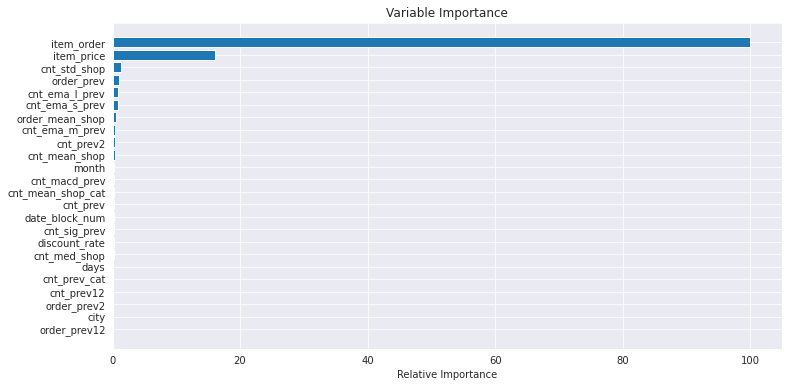

In [48]:
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

**각 피쳐의 중요도를 분석한 결과, 주문량에 대한 중요도가 가장 크게 나온 것을 확인할 수 있었습니다.**

## 07. 제출파일 만들기
- to_csv로 생성

In [49]:
pred_cnt = sub_preds
result = pd.DataFrame({
    "ID": test["ID"],
    "item_cnt_month": pred_cnt.clip(0. ,20.)
})
result.to_csv("submission.csv", index=False)

# 회고
---
- time series 모델에 대한 정의를 하는 것이 어려웠지만, 데이터를 분석하고 시간적인 정보를 피쳐로 생성함으로써 xgboost모델로 예측하는 것으로 결론을 내릴 수 있었다. 하지만 time series모델을 분석하는 방법, 회귀/분류에 대한 차이점에 대한 보충이 필요하다고 생각한다.   
- 또한 계절적 영향에 대해서 주기를 어떻게 구분하는지, 포함되어있는 개월 수는 34개월인데 이를 1년치 혹은 분기로 나누어서 분석할지에 대한 고민이 필요하다. 
- 여러 데이터 파일에서 필요한 컬럼을 가져와 학습 데이터에 포함시키는 방법에 대해서 공부할 수 있었고, 관계성이 높다고 예측한 피처가 중요도를 분석했을 때 오히려 중요하지 않다고 나오는 것을 확인할 수 있었다. 데이터를 생성하고 처리하면서 지속적으로 분석해야한다고 생각한다.
- 전체 과정을 협업하기도하고, 분업도 해보면서 어느 방식이 더 적절한지는 잘 모르겠지만, 팀원들과의 지속적인 소통이 중요했다. 
- 공개된 노트북을 분석하면서 새로운 코드 작성 방식에 대해서 공부할 수 있었다. 또한 다른 코드에 원하는 방식으로 적용하면서 여러 부분을 수정하는 방식을 배울 수 있었다. 
- 계속해서 분석하고 흐름에 대해 토의함으로써 데이터에 대한 이해도를 높일 수 있었다. 

# 결과
---
![image](https://user-images.githubusercontent.com/68461606/107471384-67833400-6bb0-11eb-96d5-2918bcef8677.png)